## Introduction to analysing and presenting ML data

This week, we'll introduce some methods to analyse and extract information from your machine learning models, then put everything together
to create a web app to demonstrate your machine learning models!

# Part 1: Representing high-dimentional data

Often with machine learning problems, we are dealing with datasets that are hard to visualise in 2 or 3 dimentions,
for example we couldn't hope to visualise even a simple dataset containing 10 features like the housing dataset earlier.


The most popular algorithm for dealing with this is Principle Component Analysis (PCA)

In [5]:
# boilerplate code to produce some 3d data for us to work with

from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d
import numpy as np


np.random.seed(4)
m = 60
w1, w2 = 0.1, 0.3
noise = 0.1

angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
X = np.empty((m, 3))
X[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * np.random.randn(m) / 2
X[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2
X[:, 2] = X[:, 0] * w1 + X[:, 1] * w2 + noise * np.random.randn(m)




PCA with sklearn is straightforward and hides the matrix computations for us

In [6]:
from sklearn.decomposition import PCA
# instantiate the PCA class to produce the principle n components
# We can also pass the retained variance here e.g. 0.95
pca = PCA(n_components=2)
X2D = pca.fit_transform(X)


# this has projected our 3D data onto a two dimentional plane defined by our two principle components, whilst maximising the variation in the transformed data


# we can reconstruct our data from the PCA representation


X3D_inv = pca.inverse_transform(X2D)

# calculate the mean square error bewteen the reconstruction and the actual data
np.mean(np.sum(np.square(X3D_inv - X), axis=1))


0.010170337792848549

The pca object we have just fitted gives us access to some useful metrics:


* Explained variance: how much of the variance in the dataset is captured by the principle components?

In [7]:
pca.explained_variance_ratio_


array([0.84248607, 0.14631839])

In [8]:
# how much variance do we lose compared to the original data?


1 - pca.explained_variance_ratio_.sum()


0.011195535570688975

## Visualising our dataset and the PCA projections



<ipython-input-15-7f2347c6872a>:47: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  ax.plot([X[i][0], X3D_inv[i][0]], [X[i][1], X3D_inv[i][1]], [X[i][2], X3D_inv[i][2]], "k-", color="#505050")
<ipython-input-15-7f2347c6872a>:12: MatplotlibDeprecationWarning: 
The M attribute was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use self.axes.M instead.
  xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)


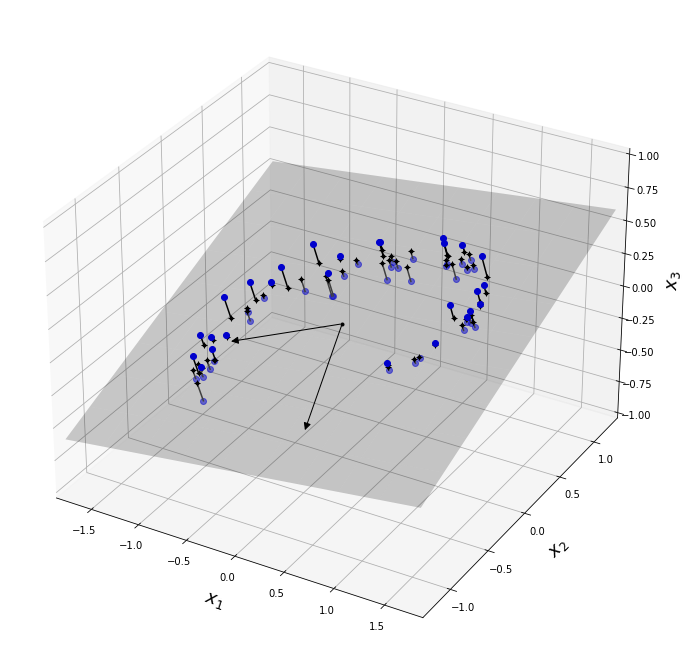

In [15]:
# ignore this bit! Just for plotting fancy bits
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d

class Arrow3D(FancyArrowPatch):
    def __init__(self, xs, ys, zs, *args, **kwargs):
        FancyArrowPatch.__init__(self, (0,0), (0,0), *args, **kwargs)
        self._verts3d = xs, ys, zs

    def draw(self, renderer):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
        self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))
        FancyArrowPatch.draw(self, renderer)

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

axes = [-1.8, 1.8, -1.3, 1.3, -1.0, 1.0]

x1s = np.linspace(axes[0], axes[1], 10)
x2s = np.linspace(axes[2], axes[3], 10)
x1, x2 = np.meshgrid(x1s, x2s)

C = pca.components_
R = C.T.dot(C)
z = (R[0, 2] * x1 + R[1, 2] * x2) / (1 - R[2, 2])

fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111, projection='3d')

X3D_above = X[X[:, 2] > X3D_inv[:, 2]]
X3D_below = X[X[:, 2] <= X3D_inv[:, 2]]

ax.plot(X3D_below[:, 0], X3D_below[:, 1], X3D_below[:, 2], "bo", alpha=0.5)

ax.plot_surface(x1, x2, z, alpha=0.2, color="k")
np.linalg.norm(C, axis=0)
ax.add_artist(Arrow3D([0, C[0, 0]],[0, C[0, 1]],[0, C[0, 2]], mutation_scale=15, lw=1, arrowstyle="-|>", color="k"))
ax.add_artist(Arrow3D([0, C[1, 0]],[0, C[1, 1]],[0, C[1, 2]], mutation_scale=15, lw=1, arrowstyle="-|>", color="k"))
ax.plot([0], [0], [0], "k.")

for i in range(m):
    if X[i, 2] > X3D_inv[i, 2]:
        ax.plot([X[i][0], X3D_inv[i][0]], [X[i][1], X3D_inv[i][1]], [X[i][2], X3D_inv[i][2]], "k-")
    else:
        ax.plot([X[i][0], X3D_inv[i][0]], [X[i][1], X3D_inv[i][1]], [X[i][2], X3D_inv[i][2]], "k-", color="#505050")

ax.plot(X3D_inv[:, 0], X3D_inv[:, 1], X3D_inv[:, 2], "k+")
ax.plot(X3D_inv[:, 0], X3D_inv[:, 1], X3D_inv[:, 2], "k.")
ax.plot(X3D_above[:, 0], X3D_above[:, 1], X3D_above[:, 2], "bo")
ax.set_xlabel("$x_1$", fontsize=18, labelpad=10)
ax.set_ylabel("$x_2$", fontsize=18, labelpad=10)
ax.set_zlabel("$x_3$", fontsize=18, labelpad=10)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])


plt.show()



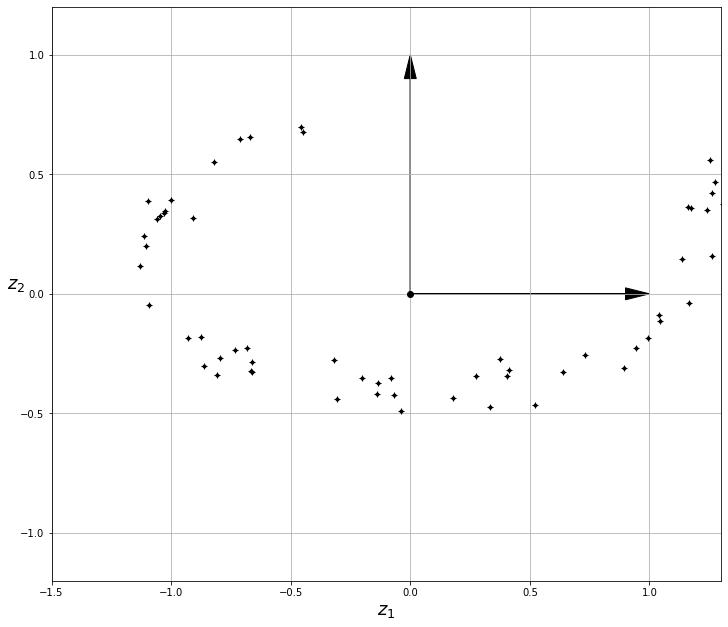

In [14]:
# visualise the 2D projection


fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111, aspect='equal')

ax.plot(X2D[:, 0], X2D[:, 1], "k+")
ax.plot(X2D[:, 0], X2D[:, 1], "k.")
ax.plot([0], [0], "ko")
ax.arrow(0, 0, 0, 1, head_width=0.05, length_includes_head=True, head_length=0.1, fc='k', ec='k')
ax.arrow(0, 0, 1, 0, head_width=0.05, length_includes_head=True, head_length=0.1, fc='k', ec='k')
ax.set_xlabel("$z_1$", fontsize=18)
ax.set_ylabel("$z_2$", fontsize=18, rotation=0)
ax.axis([-1.5, 1.3, -1.2, 1.2])
ax.grid(True)



Another useful application of dimentionality reduction, besides visualising your data, is reducing the complexity of your data
whilst training.  Since the compressed representation retains the majority of the information for a particular training instance with fewer dimentions,
it is often far quicker to train your model on the projection of your data rather than the data iselt!

### Exercise 1

* Below is the code (from last week) to load the mnist dataset.  Use a logistic regression classifier to fit the dataset, and time
how long your model takes to train using the full training set.
* Repeat the training but use a PCA projection of your dataset


In [ ]:
# Note, you can time how long this take to execute like this:
import time

t1 = time.time()
time.sleep(5) # do nothing for 5 seconds
t2 = time.time()
print(t2-t1)

In [ ]:

# load the dataset
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
X, y = mnist["data"], mnist["target"]
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

from sklearn.linear_model import LogisticRegression
# instantiate the classifier in explicit multi-class mode, specify a couple of hyperparameters
log_clf_full = LogisticRegression(multi_class="multinomial", solver="lbfgs", random_state=42)

# call the fit method using the train data and labels, wrapped with the timing code from above

# print out how long the model training took


from sklearn.decomposition import PCA
# call the fit_transform method on your instantiated PCA class, passing a variance of 95% to produce your compressed datset


# repeat the training from above using your compressed training data, compare the timings
log_clf_pca = LogisticRegression(multi_class="multinomial", solver="lbfgs", random_state=42)

# check the accuracy of both of your models
from sklearn.metrics import accuracy_score

# run the predict method on both classifiers with the test set

# calculate the accuracy score for both with the test set labels


# Cool project time!

As the final part of this course, I'm going to introduce one more cool python library that does cool stuff with the models we've built over the last few weeks.

We're going to create some visualisations using the machine learning models we've introduced during the last few sessions.

Here's one I made earlier...

https://share.streamlit.io/jharrymoore/sklearn_gui/streamlit-app.py

And if you want to refer to the source code later...

https://github.com/jharrymoore/sklearn_gui

Spend a few minutes playing around with it to get a feel for what we can do, then I'll show you how to do it.

Hopefully you recognise some of the models and datasets from work we've done in the last few weeks!

We'll use a python app called Streamlit which does all the frontend heavy lifting for us and creates beautiful apps programatically.  It's a really nice way to present and interact with data



### Instructions for running as an app
Unfortunately, streamlit doesn't play nicely with colab.  To run this yourself,
You will find all the code you need to run the app yourself in the wekk8_app folder of the repo.


#### Instructions for running app locally
On your local machine, enter the following at the command line (e.g. the integrated terminal in PyCharm), assuming you have a local python install, and you are in the intermediate_python directory

`pip install streamlit matplotlib scikit-learn numpy pandas`

`cd week8_app # make sure you are in the week8_app directory`

`streamlit run app.py`

Paste the resulting url into your browser and the app should run locally for you.




Below I've included a minimal version of the script, with comments where you should add code to create additional functionality and features.


In [ ]:
# define some utility functions to do the underlying machine learning

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn import datasets
import streamlit as st
from sklearn.model_selection import train_test_split, cross_val_score
from typing import Dict
from sklearn.neighbors import KNeighborsClassifier

def get_dataset_name(dataset_name: str):
    if dataset_name.lower() == 'iris':
        data = datasets.load_iris()
    elif dataset_name.lower() == 'wine':
        data = datasets.load_wine()
    elif dataset_name.lower() == 'breast cancer':
        data = datasets.load_breast_cancer()
    else:
        raise AssertionError('Dataset must be one of the provided options')
    # 1) Split the training data into train and test fractions for the data and labels, make sure your variable names line up with the return values!

    return X_train, X_test, y_train, y_test, data


def add_ui_params(classifier_name):
    params = {}
    if classifier_name.lower() == 'knn':
        K = st.sidebar.slider('K', 1, 15)
        params['n_neighbors'] = K
    elif classifier_name.lower() == 'svm':
        c = st.sidebar.slider('C', 0.01, 10.0)
        kernel = st.sidebar.selectbox('Kernel', ('linear', 'poly', 'rbf', 'sigmoid', 'precomputed'))
        params['C'] = c
        params['kernel'] = kernel
    elif classifier_name.lower() == 'random forest':
        max_depth = st.sidebar.slider('Max Depth', 2, 15)
        num_trees = st.sidebar.slider('n_estimators', 1, 100)
        params['max_depth'] = max_depth
        params['n_estimators'] = num_trees
    return params

def get_classifier(clf_name: str, params: Dict):
    # 2)
    # write a function to instantiate the model
    # the function takes the classifier name, and the parameter dictionary
    # You can initialise the class directly from the dictionary by passing them as key word arguments


    return model

def train_model(model, X, y, metric, k_folds):
    # 3)
    # use cross val score to calculate the cross validation score the for model using the function's arguments


    # use the fit method to train your model on the training data, make sure the variable names match the returned variable names!

    return model, results, results.mean(), results.std()



In [ ]:
# source code from https://github.com/jharrymoore/sklearn_gui

import sklearn
import streamlit as st
import numpy as np
import  matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score



st.title('Machine Learning GUI')

st.write('Example GUI application with a machine learning backend')


dataset_name = st.sidebar.selectbox('Select Dataset',
        ('Wine', 'Breast Cancer', 'Iris'))

st.write(f'Dataset Name: {dataset_name}')

classifier_name = st.sidebar.selectbox('Select Classifier',
                    ('KNN', 'SVM', 'Random Forest'))



X_train, X_test, y_train, y_test, data = get_dataset_name(dataset_name)


st.write(f'Shape of the dataset is {X_train.shape}')
st.write('Number of classes:', len(np.unique(data.target)))



params = add_ui_params(classifier_name)


model = get_classifier(classifier_name, params)

k_folds = st.sidebar.slider('Cross Validation Folds', 2, 20)
metric = st.sidebar.selectbox('Model performance metric', tuple(sklearn.metrics.SCORERS.keys()), index=11)


fitted_model, accuracy, mean, std = train_model(model, X_train, y_train, metric, k_folds)
y_pred = fitted_model.predict(X_test)
test_set_accuracy = accuracy_score(y_test, y_pred)
st.write('Cross validation Model Accuracy', mean)
st.write('Test set accuracy:', test_set_accuracy)


# plot the principle components

pca = PCA(2)

x_proj = pca.fit_transform(data.data)

x1 = x_proj[:, 0]
x2 = x_proj[:,1]

fig = plt.figure()
plt.scatter(x1, x2, c=data.target, alpha=0.8, cmap='viridis')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.colorbar()

st.pyplot(fig)



